# Used in this kernel:
* preprocessed dataset by olivier https://www.kaggle.com/ogrellier/create-extracted-json-fields-dataset
* exported google analytics data https://www.kaggle.com/satian/exported-google-analytics-data


* story of a leak v.01 https://www.kaggle.com/igauty/story-of-a-leak-v01
* future is here https://www.kaggle.com/ashishpatel26/future-is-here
* teach-lightgbm-to-sum-predictions https://www.kaggle.com/satian/story-of-a-leak/notebook


The code below is full of bugs, which I didn't remove as they seem to improve LB.

In [1]:
import pandas as pd
import numpy as np

# DRAGONS
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")

# garbage collector
import gc
gc.enable()
from sklearn.model_selection import GridSearchCV


# Loading data

In [2]:
train = pd.read_csv('./all/extracted_fields_train.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
test = pd.read_csv('./all/extracted_fields_test.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
train.shape, test.shape

((903653, 30), (804684, 30))

In [3]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1.0,1.472830e+09,Chrome,desktop,0.0,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1.0,1.472880e+09,Firefox,desktop,0.0,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1.0,1.472865e+09,Chrome,desktop,0.0,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1.0,1.472881e+09,UC Browser,desktop,0.0,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2.0,1.472823e+09,Chrome,mobile,1.0,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1.0,NaN,1.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google


In [4]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [5]:
# Getting data from leak
train_store_1 = pd.read_csv('./all/Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('./all/Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('./all/Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('./all/Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

In [6]:
# Getting VisitId from Google Analytics...
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(np.int64)

In [7]:
# Merge with train/test data
train = train.merge(pd.concat([train_store_1, train_store_2], sort=False), how="left", on="visitId")
test = test.merge(pd.concat([test_store_1, test_store_2], sort=False), how="left", on="visitId")

# Drop Client Id
for df in [train, test]:
    df.drop("Client Id", 1, inplace=True)

In [8]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'Sessions', 'Avg. Session Duration',
       'Bounce Rate', 'Revenue', 'Transactions', 'Goal Conversion Rate'],
      dtype='object')

In [9]:
# Cleaning Revenue
for df in [train, test]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

In [10]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    del df
gc.collect()

60

# Looking around

Some pictures to have in mind: target distribution

In [11]:
target_sums = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

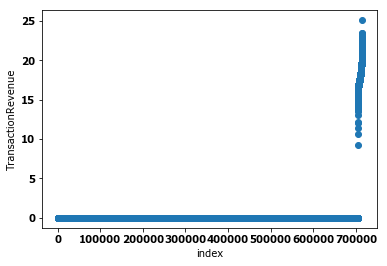

In [12]:
plt.scatter(range(target_sums.shape[0]), np.sort(np.log1p(target_sums["totals.transactionRevenue"].values)))
plt.xlabel('index')
plt.ylabel('TransactionRevenue')
plt.show()

Key problem:

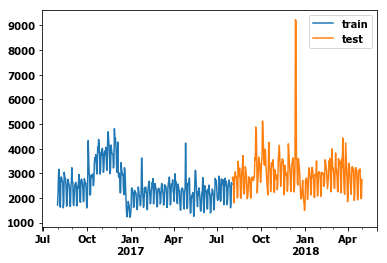

In [13]:
train.date = pd.to_datetime(train.date, format="%Y%m%d")
test.date = pd.to_datetime(test.date, format="%Y%m%d")
train.date.value_counts().sort_index().plot(label="train")
test.date.value_counts().sort_index().plot(label="test")
plt.legend()

Comparing categories in train and test:

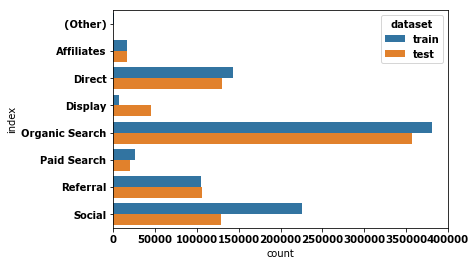

In [14]:
def drawBars(columnname):
    sns.barplot(x="count", y="index", hue="dataset",
        data=pd.melt(pd.concat([train[columnname].value_counts().rename("train"), 
                       test[columnname].value_counts().rename("test")], axis=1, sort="False").reset_index(),
            id_vars="index", var_name="dataset", value_name="count"))

drawBars("channelGrouping")

In [15]:
# d = pd.concat([train['channelGrouping'].value_counts().rename("train"), 
#                        test['channelGrouping'].value_counts().rename("test")], axis=1, sort="False").reset_index()
# pd.melt(d,id_vars="index", var_name="dataset", value_name="count")

In [16]:
# import pandas as pd
# df = pd.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
#                     'B': {0: 1, 1: 3, 2: 5},
#                     'C': {0: 2, 1: 4, 2: 6}})
# pd.melt(df, id_vars=['A'],var_name ='dateset',value_name = "count")

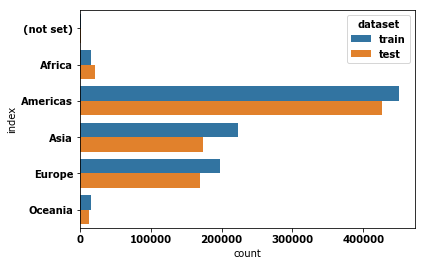

In [17]:
drawBars("geoNetwork.continent")

In [18]:
ids_train = set(train.fullVisitorId.unique())
ids_test = set(test.fullVisitorId.unique())
print("Unique visitor ids in train:", len(ids_train))
print("Unique visitor ids in test:", len(ids_test))
print("Common visitors in train and test:", len(ids_train & ids_test))

Unique visitor ids in train: 714167
Unique visitor ids in test: 617242
Common visitors in train and test: 7679


Weird "double" sessions:

In [19]:
problem = train[train.sessionId.map(train.sessionId.value_counts() == 2)].sort_values(["sessionId", 'visitStartTime'])
problem.head(10)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
212027,Organic Search,2016-08-21,0011338928267756760,0011338928267756760_1471848731,1471848731,1.0,1.471849e+09,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,China,not available in demo dataset,unknown.unknown,not available in demo dataset,Eastern Asia,NaN,2.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
82177,Organic Search,2016-08-22,0011338928267756760,0011338928267756760_1471848731,1471848731,1.0,1.471849e+09,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,China,not available in demo dataset,unknown.unknown,not available in demo dataset,Eastern Asia,NaN,2.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
848580,Referral,2016-12-31,0014884852016449602,0014884852016449602_1483257533,1483257533,2.0,1.483258e+09,Chrome,desktop,0.0,Macintosh,Los Angeles,Americas,United States,Los Angeles CA,(not set),California,Northern America,1.0,1.0,NaN,1.0,NaN,NaN,(not set),1.0,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
802550,Referral,2017-01-01,0014884852016449602,0014884852016449602_1483257533,1483257533,2.0,1.483258e+09,Chrome,desktop,0.0,Macintosh,Los Angeles,Americas,United States,Los Angeles CA,(not set),California,Northern America,NaN,10.0,NaN,6.0,NaN,NaN,(not set),1.0,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
428608,Organic Search,2017-06-05,0019612470994343873,0019612470994343873_1496731675,1496731675,24.0,1.496732e+09,Chrome,desktop,0.0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,NaN,14.0,NaN,14.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
202288,Organic Search,2017-06-06,0019612470994343873,0019612470994343873_1496731675,1496731675,24.0,1.496732e+09,Chrome,desktop,0.0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,NaN,2.0,NaN,2.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
46654,Paid Search,2017-05-19,0031542961723593073,0031542961723593073_1495261490,1495261490,1.0,1.495261e+09,Chrome,tablet,1.0,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,comcast.net,not available in demo dataset,Northern America,NaN,37.0,1.0,32.0,NaN,{KeyWord:Google Brand Items},AW - Accessories,NaN,+google +tshirt +store,cpc,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
857847,Paid Search,2017-05-20,0031542961723593073,0031542961723593073_1495261490,1495261490,1.0,1.495264e+09,Chrome,tablet,1.0,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,comcast.net,not available in demo dataset,Northern America,NaN,5.0,1.0,4.0,NaN,{KeyWord:Google Brand Items},AW - Accessories,NaN,+google +tshirt +store,cpc,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
618668,Referral,2017-01-24,0039798900163330977,0039798900163330977_1485331011,1485331011,4.0,1.485331e+09,Chrome,desktop,0.0,Macintosh,(not set),Asia,Singapore,(not set),(not set),(not set),Southeast Asia,NaN,5.0,NaN,5.0,NaN,NaN,(not set),1.0,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
520543,Referral,2017-01-25,0039798900163330977,0039798900163330977_1485331011,1485331011,4.0,1.485331e+09,Chrome,desktop,0.0,Macintosh,(not set),Asia,Singapore,(not set),(not set),(no

VisitStartTime seems to be same thing as visitId... yet not always!

In [20]:
(train.visitStartTime == train.visitId).value_counts()

True     898945
False      4709
dtype: int64

Suspicious simultaneous visitors with same visitorId and same visitStartTime:

In [21]:
train.loc[pd.to_datetime(train.visitStartTime, unit='s') == "2017-04-25 18:49:35"].head(8)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
258149,Direct,2017-04-25,2416319035096969159,2416319035096969159_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,2.0,1.0,2.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258251,Direct,2017-04-25,5875467051006180209,5875467051006180209_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,4.0,1.0,4.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258415,Direct,2017-04-25,3888067253787916439,3888067253787916439_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,7.0,1.0,7.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258455,Direct,2017-04-25,0579533224601930433,0579533224601930433_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,8.0,1.0,8.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258470,Direct,2017-04-25,956161522071607688,956161522071607688_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,9.0,1.0,9.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258523,Direct,2017-04-25,2943475894610901056,2943475894610901056_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,12.0,1.0,12.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258583,Direct,2017-04-25,715403851793675702,715403851793675702_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,16.0,1.0,8.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
259881,Direct,2017-04-25,2234027337409555263,2234027337409555263_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,3.0,1.0,3.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN


Seems to be a serious problem:

In [22]:
print("Train: ", np.bincount(train.visitId.value_counts()))

Train:  [     0 869451  16411    396     38      3      3      0      1]


In [23]:
print("test: ", np.bincount(test.visitId.value_counts()))

test:  [     0 759983  17804    978    262    110     62     36     18     17
     24     12     15     24     22     24     19     21     21     23
      9      8      5      2      2      0      1      0      2]


# Preprocessing

Setting time as index and saving time as feature (for FE purposes only)

In [24]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [25]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

Clearing rare categories and setting 0 to NaNs:

In [26]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [27]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [28]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 98 device.browser categories to 'other'; now there are 11 categories in train
Set 15 device.operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork.country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork.city categories to 'other'; now there are 77 categories in train
Set 86 geoNetwork.metro categories to 'other'; now there are 24 categories in train
Set 25689 geoNetwork.networkDomain categories to 'other'; now there are 62 categories in train
Set 314 geoNetwork.region categories to 'other'; now there are 62 categories in train
Set 5 geoNetwork.subContinent categories to 'other'; now there are 19 categories in train
Set 46 trafficSource.adContent categories to 'other'; now there are 4 categories in train
Set 23 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource.keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource.medium categor

In [29]:
# Clearing leaked data:
for df in [train, test]:
    df["Avg. Session Duration"][df["Avg. Session Duration"] == 0] = "00:00:00"
    df["Avg. Session Duration"] = df["Avg. Session Duration"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
    df["Bounce Rate"] = df["Bounce Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

# Features

Based on strange things in dataset:

In [30]:
# for df in [train, test]:
#     # remember these features were equal, but not always? May be it means something...
#     df["id_incoherence"] = pd.to_datetime(df.visitId, unit='s') != df.date
#     # remember visitId dublicates?
#     df["visitId_dublicates"] = df.visitId.map(df.visitId.value_counts())
#     # remember session dublicates?
#     df["session_dublicates"] = df.sessionId.map(df.sessionId.value_counts())

Basic time features:

In [31]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!

Looking to future features (from https://www.kaggle.com/ashishpatel26/future-is-here):

In [32]:
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60

df['prev_session_1'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(2)).astype(np.int64) // 1e9 // 60 // 60
df['next_session_1'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-2)).astype(np.int64) // 1e9 // 60 // 60

df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

Paired categories from "teach-lightgbm-to-sum-predictions" kernel

In [33]:
for df in [train, test]:
    df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

In [34]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content.source'] = df['trafficSource.adContent'].astype(str) + "_" + df['source.country']
    df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']

User-aggregating features:

In [35]:
for feature in ["totals.hits", "totals.pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

# Encoding features

In [36]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [37]:
train[cat_cols].nunique()

channelGrouping                                       8
device.browser                                       11
device.deviceCategory                                 3
device.operatingSystem                                8
geoNetwork.city                                      77
geoNetwork.continent                                  6
geoNetwork.country                                   60
geoNetwork.metro                                     24
geoNetwork.networkDomain                             62
geoNetwork.region                                    62
geoNetwork.subContinent                              19
trafficSource.adContent                               4
trafficSource.campaign                                5
trafficSource.keyword                                 8
trafficSource.medium                                  7
trafficSource.referralPath                           17
trafficSource.source                                 22
weekday                                         

In [38]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [39]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [40]:
train[real_cols + cat_cols].head()

,visitNumber,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.isTrueDirect,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,time,prev_session,next_session,prev_session_1,next_session_1,usermean_totals.hits,usermean_totals.pageviews,usermax_visitNumber,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,source.country,campaign.medium,browser.category,browser.os,device_deviceCategory_channelGrouping,channelGrouping_browser,channelGrouping_OS,geoNetwork.city_device.browser,geoNetwork.city_device.deviceCategory,geoNetwork.city_device.operatingSystem,geoNetwork.city_trafficSource.source,geoNetwork.continent_device.browser,geoNetwork.continent_device.deviceCategory,geoNetwork.continent_device.operatingSystem,geoNetwork.continent_trafficSource.source,geoNetwork.country_device.browser,geoNetwork.country_device.deviceCategory,geoNetwork.country_device.operatingSystem,geoNetwork.country_trafficSource.source,geoNetwork.metro_device.browser,geoNetwork.metro_device.deviceCategory,geoNetwork.metro_device.operatingSystem,geoNetwork.metro_trafficSource.source,geoNetwork.networkDomain_device.browser,geoNetwork.networkDomain_device.deviceCategory,geoNetwork.networkDomain_device.operatingSystem,geoNetwork.networkDomain_trafficSource.source,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,3.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25212.0,-2562048.0,-2562048.0,-2562048.0,-2562048.0,1.0,1.0,3.0,2,7,1,6,75,2,57,22,0,61,8,0,1,4,0,24,0,0,57,1,25,37,10,62,50,831,226,564,1359,31,7,22,37,676,172,459,1032,252,67,170,442,7,1,6,0,701,184,471,1103,103,25,70,153,57,57
2016-08-01 07:04:26,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25466.0,-2562048.0,-2562048.0,-2562048.0,-2562048.0,1.0,1.0,1.0,7,1,0,5,75,3,52,22,51,61,11,0,1,4,6,14,21,0,1084,7,3,6,7,14,47,825,225,563,1380,37,9,29,80,610,156,418,956,246,66,169,463,559,153,405,930,695,183,470,1124,133,33,93,239,1084,1237
2016-08-01 07:04:41,1.0,1.0,0.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25481.0,-2562048.0,-2562048.0,-2562048.0,-2562048.0,5.0,5.0,1.0,4,11,2,1,75,2,57,22,0,61,8,0,1,3,4,24,8,0,518,5,35,49,20,86,12,835,227,559,1367,35,8,17,45,680,173,454,1040,256,68,165,450,11,2,1,8,705,185,466,1111,107,26,65,161,518,393
2016-08-01 07:06:01,1.0,0.0,0.0,9.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25561.0,-2562048.0,-2562048.0,-2562048.0,-2562048.0,9.0,7.0,1.0,4,1,0,5,75,2,8,22,8,61,8,0,1,3,4,24,8,0,469,5,3,6,4,11,44,825,225,563,1367,25,6,21,45,96,24,69,149,246,66,169,450,90,24,69,151,695,183,470,1111,97,24,69,161,469,344
2016-08-01 07:06:10,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25570.0,-2562048.0,-2562048.0,-2562048.0,-2562048.0,1.0,1.0,1.0,2,1,0,5,76,3,36,0,29,62,11,0,1,4,0,24,0,0,36,1,3,6,2,9,42,837,228,571,1381,37,9,29,59,422,108,290,651,1,0,5,0,319,87,233,527,707,186,478,1125,133,33,93,218,36,36


In [41]:
for to_del in ["date", "sessionId", "visitId", "day"]:
    del train[to_del]
    del test[to_del]

# Preparing validation

In [42]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', "month", "help"]

cat_cols = [f for f in train.columns if (train[f].dtype == 'int64' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

Function to tell us the score using the metric we actually care about

In [43]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

Cute function to validate and prepare stacking

In [44]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [45]:
Kfolder = KFoldValidation(train)

In [46]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse",bagging_frequency=5, 
                      bagging_seed=2019, use_best_model=True,bagging_fraction = 0.7,feature_fraction= 0.7,min_child_samples = 150,num_leaves = 31,learning_rate=0.03)

In [47]:
# ML tuning hyperparamer
# parameters = {'num_leaves': [31,50], 'min_child_samples': [50, 150],'bagging_fraction': [0.5,0.8],'feature_fraction': [0.5,0.8],'subsample': [0.7,0.9], 'colsample_bytree' :[0.7,0.9]}
# train_X = train[real_cols + cat_cols]
# train_y = np.log1p(train['totals.transactionRevenue'].values)
# clf = GridSearchCV(lgbmodel,parameters,cv = 5)
# clf.fit(train_X,train_y)
# clf.get_params()


In [48]:
# clf.best_params_
# clf.cv_results_


In [49]:
train_X = train[feature]

In [50]:
Kfolder.validate(train, test, real_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61081
[200]	valid_0's rmse: 1.58651
[300]	valid_0's rmse: 1.58046
[400]	valid_0's rmse: 1.57725
[500]	valid_0's rmse: 1.57637
[600]	valid_0's rmse: 1.5755
[700]	valid_0's rmse: 1.57516
[800]	valid_0's rmse: 1.57454
Early stopping, best iteration is:
[833]	valid_0's rmse: 1.57428
Fold  0  error:  1.5726727246070442
Fold  0  score:  1.5550348674796681
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.58557
[200]	valid_0's rmse: 1.56615
[300]	valid_0's rmse: 1.56071
[400]	valid_0's rmse: 1.558
[500]	valid_0's rmse: 1.55672
[600]	valid_0's rmse: 1.55564
[700]	valid_0's rmse: 1.55508
[800]	valid_0's rmse: 1.55451
Early stopping, best iteration is:
[815]	valid_0's rmse: 1.55433
Fold  1  error:  1.5527806216987983
Fold  1  score:  1.5574260089727416
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.59684
[20

1.5507844168093747

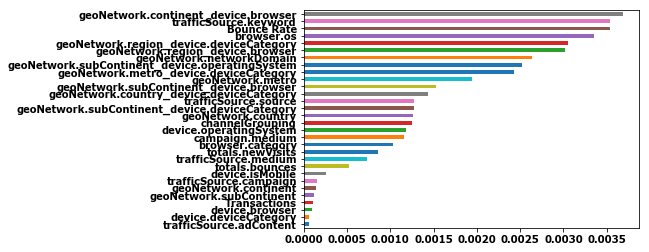

In [51]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh")

# User-level

Make one user one object:
* all features are averaged
* we hope, that categorical features do not change for one user (that's not true :/ )
* categoricals labels are averaged (!!!) and are treated as numerical features (o_O)
* predictions are averaged in multiple ways...

In [52]:
def create_user_df(df):
    agg_data = df[real_cols + cat_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()
    
    pred_list = df[['fullVisitorId', 'lgbpred']].groupby('fullVisitorId').apply(lambda visitor_df: list(visitor_df.lgbpred))\
        .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    all_predictions = pd.DataFrame(list(pred_list.values), index=agg_data.index)
    feats = all_predictions.columns

    all_predictions['t_mean'] = all_predictions.mean(axis=1)
    all_predictions['t_median'] = all_predictions.median(axis=1)   # including t_mean as one of the elements? well, ok
    all_predictions['t_sum_log'] = all_predictions.sum(axis=1)
    all_predictions['t_sum_act'] = all_predictions.fillna(0).sum(axis=1)
    all_predictions['t_nb_sess'] = all_predictions.isnull().sum(axis=1)

    full_data = pd.concat([agg_data, all_predictions], axis=1).astype(float)
    full_data['fullVisitorId'] = full_data.index
    del agg_data, all_predictions
    gc.collect()
    return full_data

In [53]:
user_train = create_user_df(train)
user_test = create_user_df(test)

In [54]:
features = list(user_train.columns)[:-1]  # don't include "fullVisitorId"
user_train["totals.transactionRevenue"] = train[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()

In [55]:
for f in features:
    if f not in user_test.columns:
        user_test[f] = np.nan

# Meta-models

In [56]:
Kfolder = KFoldValidation(user_train)

In [57]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [58]:
Kfolder.validate(user_train, user_test, features, lgbmodel, name="lgbfinal", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50533
[200]	valid_0's rmse: 1.4996
Early stopping, best iteration is:
[160]	valid_0's rmse: 1.49932
Fold  0  error:  1.4992440661410875
Fold  0  score:  1.4992440661410875
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.51118
[200]	valid_0's rmse: 1.50819
Early stopping, best iteration is:
[150]	valid_0's rmse: 1.50731
Fold  1  error:  1.507275373633921
Fold  1  score:  1.507275373633921
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50669
[200]	valid_0's rmse: 1.50199
Early stopping, best iteration is:
[177]	valid_0's rmse: 1.50183
Fold  2  error:  1.5017855212157227
Fold  2  score:  1.5017855212157227
Fold  3 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.48741
[200]	valid_0's rmse: 1.48268
Early stopping, best iteration is:
[245]	valid_0's rmse: 1.48246

1.499757012661017

In [59]:
xgbmodel = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)

In [60]:
Kfolder.validate(user_train, user_test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[0]	validation_0-rmse:2.09604
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.65637
[200]	validation_0-rmse:1.54695
[300]	validation_0-rmse:1.5283
[400]	validation_0-rmse:1.5253
Stopping. Best iteration:
[424]	validation_0-rmse:1.52512

Fold  0  error:  1.5249892879205527
Fold  0  score:  1.5249892879271056
Fold  1 :
[0]	validation_0-rmse:2.10216
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.65499
[200]	validation_0-rmse:1.5578
[300]	validation_0-rmse:1.53723
[400]	validation_0-rmse:1.53006
[500]	validation_0-rmse:1.52855
Stopping. Best iteration:
[519]	validation_0-rmse:1.52845

Fold  1  error:  1.5284323339192187
Fold  1  score:  1.52843233392318
Fold  2 :
[0]	validation_0-rmse:2.10516
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.65195
[200]	validation_0-rmse:1.548
[300]	validation_0-rmse:1.52873
[400]	validation_0-rmse:1.52388
[500]	validati

1.5232206990572172

In [61]:
catmodel = cat.CatBoostRegressor(iterations=500, learning_rate=0.2, depth=5, random_seed=2019)

In [62]:
Kfolder.validate(user_train, user_test, features, catmodel, name="catfinal", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

Fold  0 :
0:	learn: 1.9264084	test: 1.9272649	best: 1.9272649 (0)	total: 850ms	remaining: 7m 4s
100:	learn: 1.4657960	test: 1.5040523	best: 1.5037197 (88)	total: 1m 21s	remaining: 5m 23s
200:	learn: 1.4373705	test: 1.5060004	best: 1.5037197 (88)	total: 2m 39s	remaining: 3m 56s
300:	learn: 1.4133794	test: 1.5092214	best: 1.5037197 (88)	total: 3m 58s	remaining: 2m 37s
400:	learn: 1.3920576	test: 1.5111162	best: 1.5037197 (88)	total: 5m 14s	remaining: 1m 17s
499:	learn: 1.3740084	test: 1.5136180	best: 1.5037197 (88)	total: 6m 28s	remaining: 0us

bestTest = 1.503719738
bestIteration = 88

Shrink model to first 89 iterations.
Fold  0  error:  1.5036667796271916
Fold  0  score:  1.5036667796271916
Fold  1 :
0:	learn: 1.9271407	test: 1.9328981	best: 1.9328981 (0)	total: 705ms	remaining: 5m 51s
100:	learn: 1.4650738	test: 1.5121537	best: 1.5105784 (70)	total: 1m 14s	remaining: 4m 56s
200:	learn: 1.4377999	test: 1.5159934	best: 1.5105784 (70)	total: 2m 29s	remaining: 3m 41s
300:	learn: 1.414134

1.5027367483443888

# Ensembling dragons

In [63]:
user_train['PredictedLogRevenue'] = 0.4 * user_train["lgbfinal"] + \
                                    0.2 * user_train["xgbfinal"] + \
                                    0.4 * user_train["catfinal"]
score(user_train, user_train.PredictedLogRevenue)

1.4983504412554733

In [64]:
user_test['PredictedLogRevenue'] = 0.4 * user_test["lgbfinal"] +  0.4 * user_test["catfinal"] + 0.2 * user_test["xgbfinal"]
user_test[['PredictedLogRevenue']].to_csv('leaky_submission.csv', index=True)